In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import logging
import os
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hintrospection as hintros
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hs3 as hs3
import oms as oms

In [6]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4294_Research_PnL_cannot_be_computed_for_C3a'
  hash='478993fee'
  # Last commits:
    * 478993fee Nina Lee linter                                                            (18 minutes ago) Tue May 2 11:32:34 2023  (HEAD -> CmTask4294_Research_PnL_cannot_be_computed_for_C3a)
    * 880f38cdb Nina Lee checkpoint                                                        (21 minutes ago) Tue May 2 11:29:39 2023           
    * b5292d19c Nina Lee checkpoint                                                        (   2 hours ago) Tue May 2 09:33:52 2023  (origin/CmTask4294_Researc

# Build the reconciliation config

In [7]:
# Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
# in the system reconciliation flow.
config = cconfig.get_config_from_env()
#
if config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    prod_data_root_dir = "/shared_data/ecs/preprod/system_reconciliation"
    dag_builder_name = "C3a"
    start_timestamp_as_str = "20230427_131000"
    end_timestamp_as_str = "20230428_130500"
    mode = "scheduled"
    save_plots_for_investors = True
    html_bucket_path = henv.execute_repo_config_code("get_html_bucket_path()")
    s3_dst_dir = os.path.join(html_bucket_path, "pnl_for_investors")
    config_list = oms.build_prod_pnl_real_time_observer_configs(
        prod_data_root_dir,
        dag_builder_name,
        start_timestamp_as_str,
        end_timestamp_as_str,
        mode,
        save_plots_for_investors,
        s3_dst_dir=s3_dst_dir,
    )
    config = config_list[0]
print(config)

INFO  Using hardwired config
INFO  run_date='20230427'
INFO  Using run_date=20230427
INFO  system_log_dir='system_log_dir.scheduled.20230427_131000.20230428_130500'
meta: 
  dag_builder_name: C3a
  date_str: 20230427
  bar_duration: 5T
  save_plots_for_investors: True
s3_dst_dir: s3://cryptokaizen-html/test
system_log_dir: /shared_data/ecs/preprod/system_reconciliation/C3a/20230427/system_log_dir.scheduled.20230427_131000.20230428_130500
system_config_func_as_str: dataflow_orange.system.Cx.get_Cx_system_config_template_instance('C3a')
research_forecast_evaluator_from_prices: 
  init: 
    price_col: vwap
    prediction_col: feature
    volatility_col: garman_klass_vol
  annotate_forecasts_kwargs: 
    style: cross_sectional
    quantization: asset_specific
    liquidate_at_end_of_day: False
    initialize_beginning_of_day_trades_to_zero: False
    burn_in_bars: 3
    asset_id_to_share_decimals: 
      6051632686: 0
      8717633868: 0
      2540896331: 0
      1528092593: 0
      89681

# Specify data to load

In [8]:
# Points to `system_log_dir/dag/node_io/node_io.data`.
data_type = "dag_data"
dag_data_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("dag_data_path=%s", dag_data_path)
# Points to `system_log_dir/dag/node_io/node_io.prof`.
data_type = "dag_stats"
dag_info_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("dag_info_path=%s", dag_info_path)
# Points to `system_log_dir/process_forecasts/portfolio`.
data_type = "portfolio"
portfolio_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("portfolio_path=%s", portfolio_path)
# Points to `system_log_dir/process_forecasts/orders`.
data_type = "orders"
orders_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("orders_path=%s", orders_path)

INFO  dag_data_path=/shared_data/ecs/preprod/system_reconciliation/C3a/20230427/system_log_dir.scheduled.20230427_131000.20230428_130500/dag/node_io/node_io.data
INFO  dag_info_path=/shared_data/ecs/preprod/system_reconciliation/C3a/20230427/system_log_dir.scheduled.20230427_131000.20230428_130500/dag/node_io/node_io.prof
INFO  portfolio_path=/shared_data/ecs/preprod/system_reconciliation/C3a/20230427/system_log_dir.scheduled.20230427_131000.20230428_130500/process_forecasts/portfolio
INFO  orders_path=/shared_data/ecs/preprod/system_reconciliation/C3a/20230427/system_log_dir.scheduled.20230427_131000.20230428_130500/process_forecasts/orders


# System config

In [9]:
# TODO(Grisha): Load the system config as df instead of just printing the DAG config.
system_config = hintros.get_function_from_string(
    config["system_config_func_as_str"]
)
print(system_config)

dag_config: 
  compute_bar_feature: 
    in_col_groups: [('close',), ('high',), ('low',)]
    out_col_group: ()
    transformer_kwargs: 
      close_col: close
      high_col: high
      low_col: low
    drop_nans: True
  resample: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',), ('stochastic',), ('volume',)]
    out_col_group: ()
    transformer_kwargs: 
      rule: 5T
      resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': 1}), ({'close': 'twap'}, 'mean', {})]
      vwap_groups: [('close', 'volume', 'vwap'), ('stochastic', 'volume', 'cmf')]
    reindex_like_input: False
    join_output_with_input: False
  compute_vol: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',)]
    out_col_group: ()
    transformer_kwargs: 
      estimators: ['close', 'parkinson', 'garman_klass']
      open_col: open
      high_col: high
    

# DAG io

## Load

In [10]:
# Get DAG node names.
dag_node_names = oms.get_dag_node_names(dag_data_path)
_LOG.info(
    "First node='%s' / Last node='%s'", dag_node_names[0], dag_node_names[-1]
)

INFO  First node='predict.0.read_data' / Last node='predict.5.process_forecasts'


In [11]:
# Get timestamps for the last DAG node.
dag_node_timestamps = oms.get_dag_node_timestamps(
    dag_data_path, dag_node_names[-1], as_timestamp=True
)
_LOG.info(
    "First timestamp='%s'/ Last timestamp='%s'",
    dag_node_timestamps[0][0],
    dag_node_timestamps[-1][0],
)

INFO  First timestamp='2023-04-27 09:10:00-04:00'/ Last timestamp='2023-04-28 09:05:00-04:00'


In [13]:
# Get DAG output for the last node and the last timestamp.
dag_df_prod = oms.load_dag_outputs(dag_data_path, dag_node_names[-1])
_LOG.info("Output of last node:")
hpandas.df_to_str(dag_df_prod, num_rows=5, log_level=logging.INFO)

INFO  Output of last node:


feature                                                                                                                                                                                                                                                                          close_vol                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                                                                                                                                                                         parkinson_vol                                                                                                                                                                                                                                                                              close                                                                                                                                                                                                                                                                                cmf                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                             volume                                                                                                                                                                                                                                                                                vwap                                                                                                                                                                                                                                                                              
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 238489

## Compute DAG execution time

In [14]:
df_dag_execution_time = oms.get_execution_time_for_all_dag_nodes(dag_data_path)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time, num_rows=5, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
2023-04-27 09:10:00-04:00,7.088,1.022,1.393,1.637,1.105,0.978,0.953
2023-04-27 09:15:00-04:00,7.076,1.023,1.369,1.619,1.125,0.981,0.959
,...,...,...,...,...,...,...
2023-04-28 09:00:00-04:00,10.361,1.014,2.064,2.274,1.757,1.631,1.621
2023-04-28 09:05:00-04:00,10.338,1.022,2.041,2.276,1.766,1.615,1.618


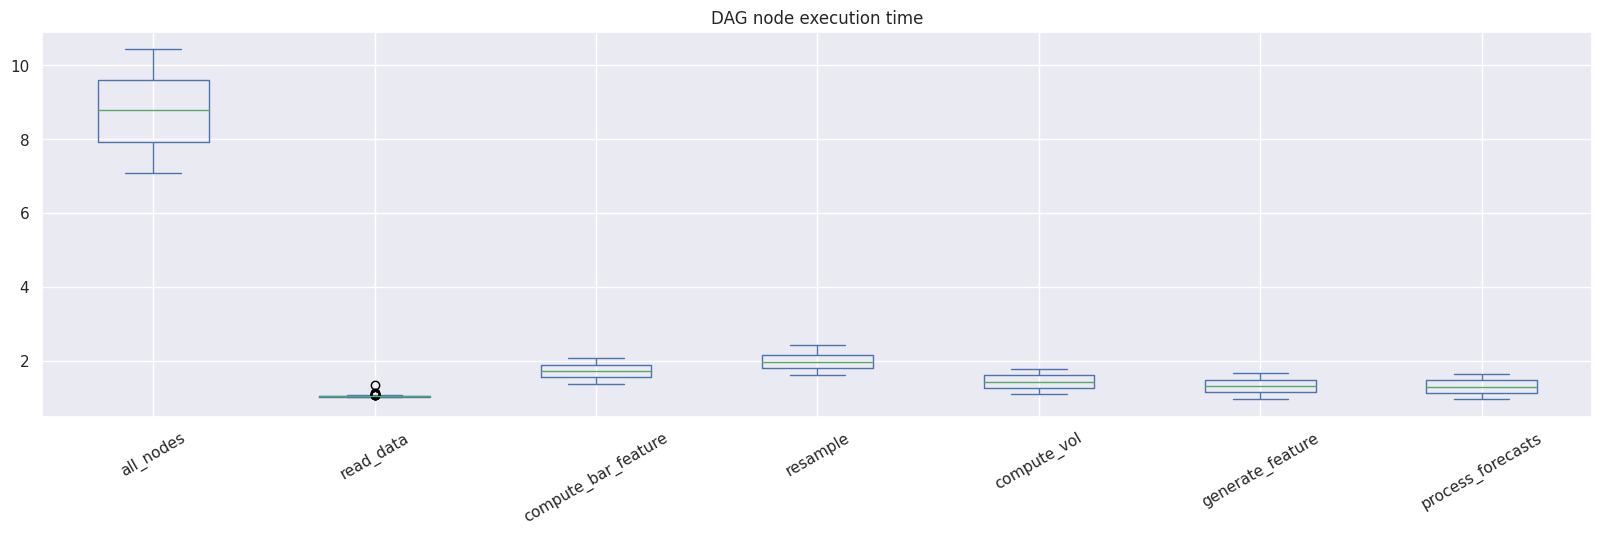

In [15]:
oms.plot_dag_execution_stats(df_dag_execution_time, report_stats=False)

In [16]:
# The time is an approximation of how long it takes to process a bar. Technically the time
# is a distance (in secs) between wall clock time when an order is executed and a bar
# timestamp. The assumption is that order execution is the very last stage.
df_order_execution_time = oms.get_orders_execution_time(orders_path)
# TODO(Grisha): consider adding an assertion that checks that the time does not
# exceed one minute.
_LOG.info(
    "Max order execution time=%s secs",
    df_order_execution_time["execution_time"].max(),
)

INFO  Max order execution time=36 secs


# Portfolio

## Compute research portfolio equivalent

In [17]:
# Set Portofolio start and end timestamps.
start_timestamp = dag_node_timestamps[0][0]
end_timestamp = dag_node_timestamps[-1][0]
_LOG.info("start_timestamp=%s", start_timestamp)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-04-27 09:10:00-04:00
INFO  end_timestamp=2023-04-28 09:05:00-04:00


In [18]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["research_forecast_evaluator_from_prices"]["init"]
)
annotate_forecasts_kwargs = config["research_forecast_evaluator_from_prices"][
    "annotate_forecasts_kwargs"
].to_dict()
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    dag_df_prod,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(gp): Move it to annotate_forecasts?
research_portfolio_df = research_portfolio_df.sort_index(axis=1)
# Align index with prod portfolio.
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2023-04-27 09:25:00-04:00,-0.243086,4169.912328,303.379422,2983.968006,-167.327533,24.0,0.0,-2.0
2023-04-27 09:30:00-04:00,0.148994,4536.211056,924.925448,3010.415414,757.746909,24.0,0.0,4.0
,...,...,...,...,...,...,...,...
2023-04-28 09:00:00-04:00,-0.301637,3136.743055,294.040663,2972.53525,158.024724,24.0,0.0,0.0
2023-04-28 09:05:00-04:00,-0.455833,3529.903131,661.733059,3004.845292,819.30195,24.0,0.0,-4.0


## Load logged portfolios (prod & research)

In [19]:
portfolio_dfs, portfolio_stats_dfs = oms.load_portfolio_dfs(
    {"prod": portfolio_path},
    config["meta"]["bar_duration"],
)
# Add research portfolio.
portfolio_dfs["research"] = research_portfolio_df
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/system_reconciliation/C3a/20230427/system_log_dir.scheduled.20230427_131000.20230428_130500/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                         holdings_notional                                                                                                                                                                                                                                                                              executed_trades_shares                                                                                                                                                                                                                                                                         executed_trades_notional                                                                                                                                                                                                                                                                                    pnl                                                                                                                                                                                                                                                                        
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510  2384892553 2425308589 2476706208 2484635488 2540896331  2601760471 2683705052  3065029174 3401245610 4516629366 5115052901  5118394986 6051632686 8717633868 8968126878 9872743573             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901  3065029174 3401245610 1464553467 1966583502 1030828978  2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608  2384892553  5118394986 1891737434 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2023-04-27 09:10:00-04:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0         0.0        0.0         0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    

In [20]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                      research                                                                  
                                pnl gross_volume  net_volume          gmv         nmv        cash  net_wealth  leverage       pnl gross_volume  net_volume          gmv         nmv   gpc  npc  wnl
2023-04-27 09:10:00-04:00       NaN          0.0         0.0          0.0         0.0       700.0       700.0       0.0       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
2023-04-27 09:15:00-04:00       0.0  3017.492164  480.577396  3017.492164  480.577396  219.422604       700.0  4.310703       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
                                ...          ...         ...          ...         ...         ...         ...       ...       ...          ...         ...          ...         ...   ...  ...  ...
2023-04-28 09:00:00-04:00 -0.016864  3132.120404  298.564388  2969.892188  162.699436    526.2091  688.908536  4.311011 -0.301637  3136.743055  294.040663   2972.53525  158.024724  24.0  0.0  0.0
2023-04-28 09:05:00-04:00  -0.69895   3516.67679  666.605586  2996.022176  828.650432 -140.396486  688.253946  4.353077 -0.455833  3529.903131  661.733059  3004.845292   819.30195  24.0  0.0 -4.0

## Compute Portfolio statistics (prod vs research)

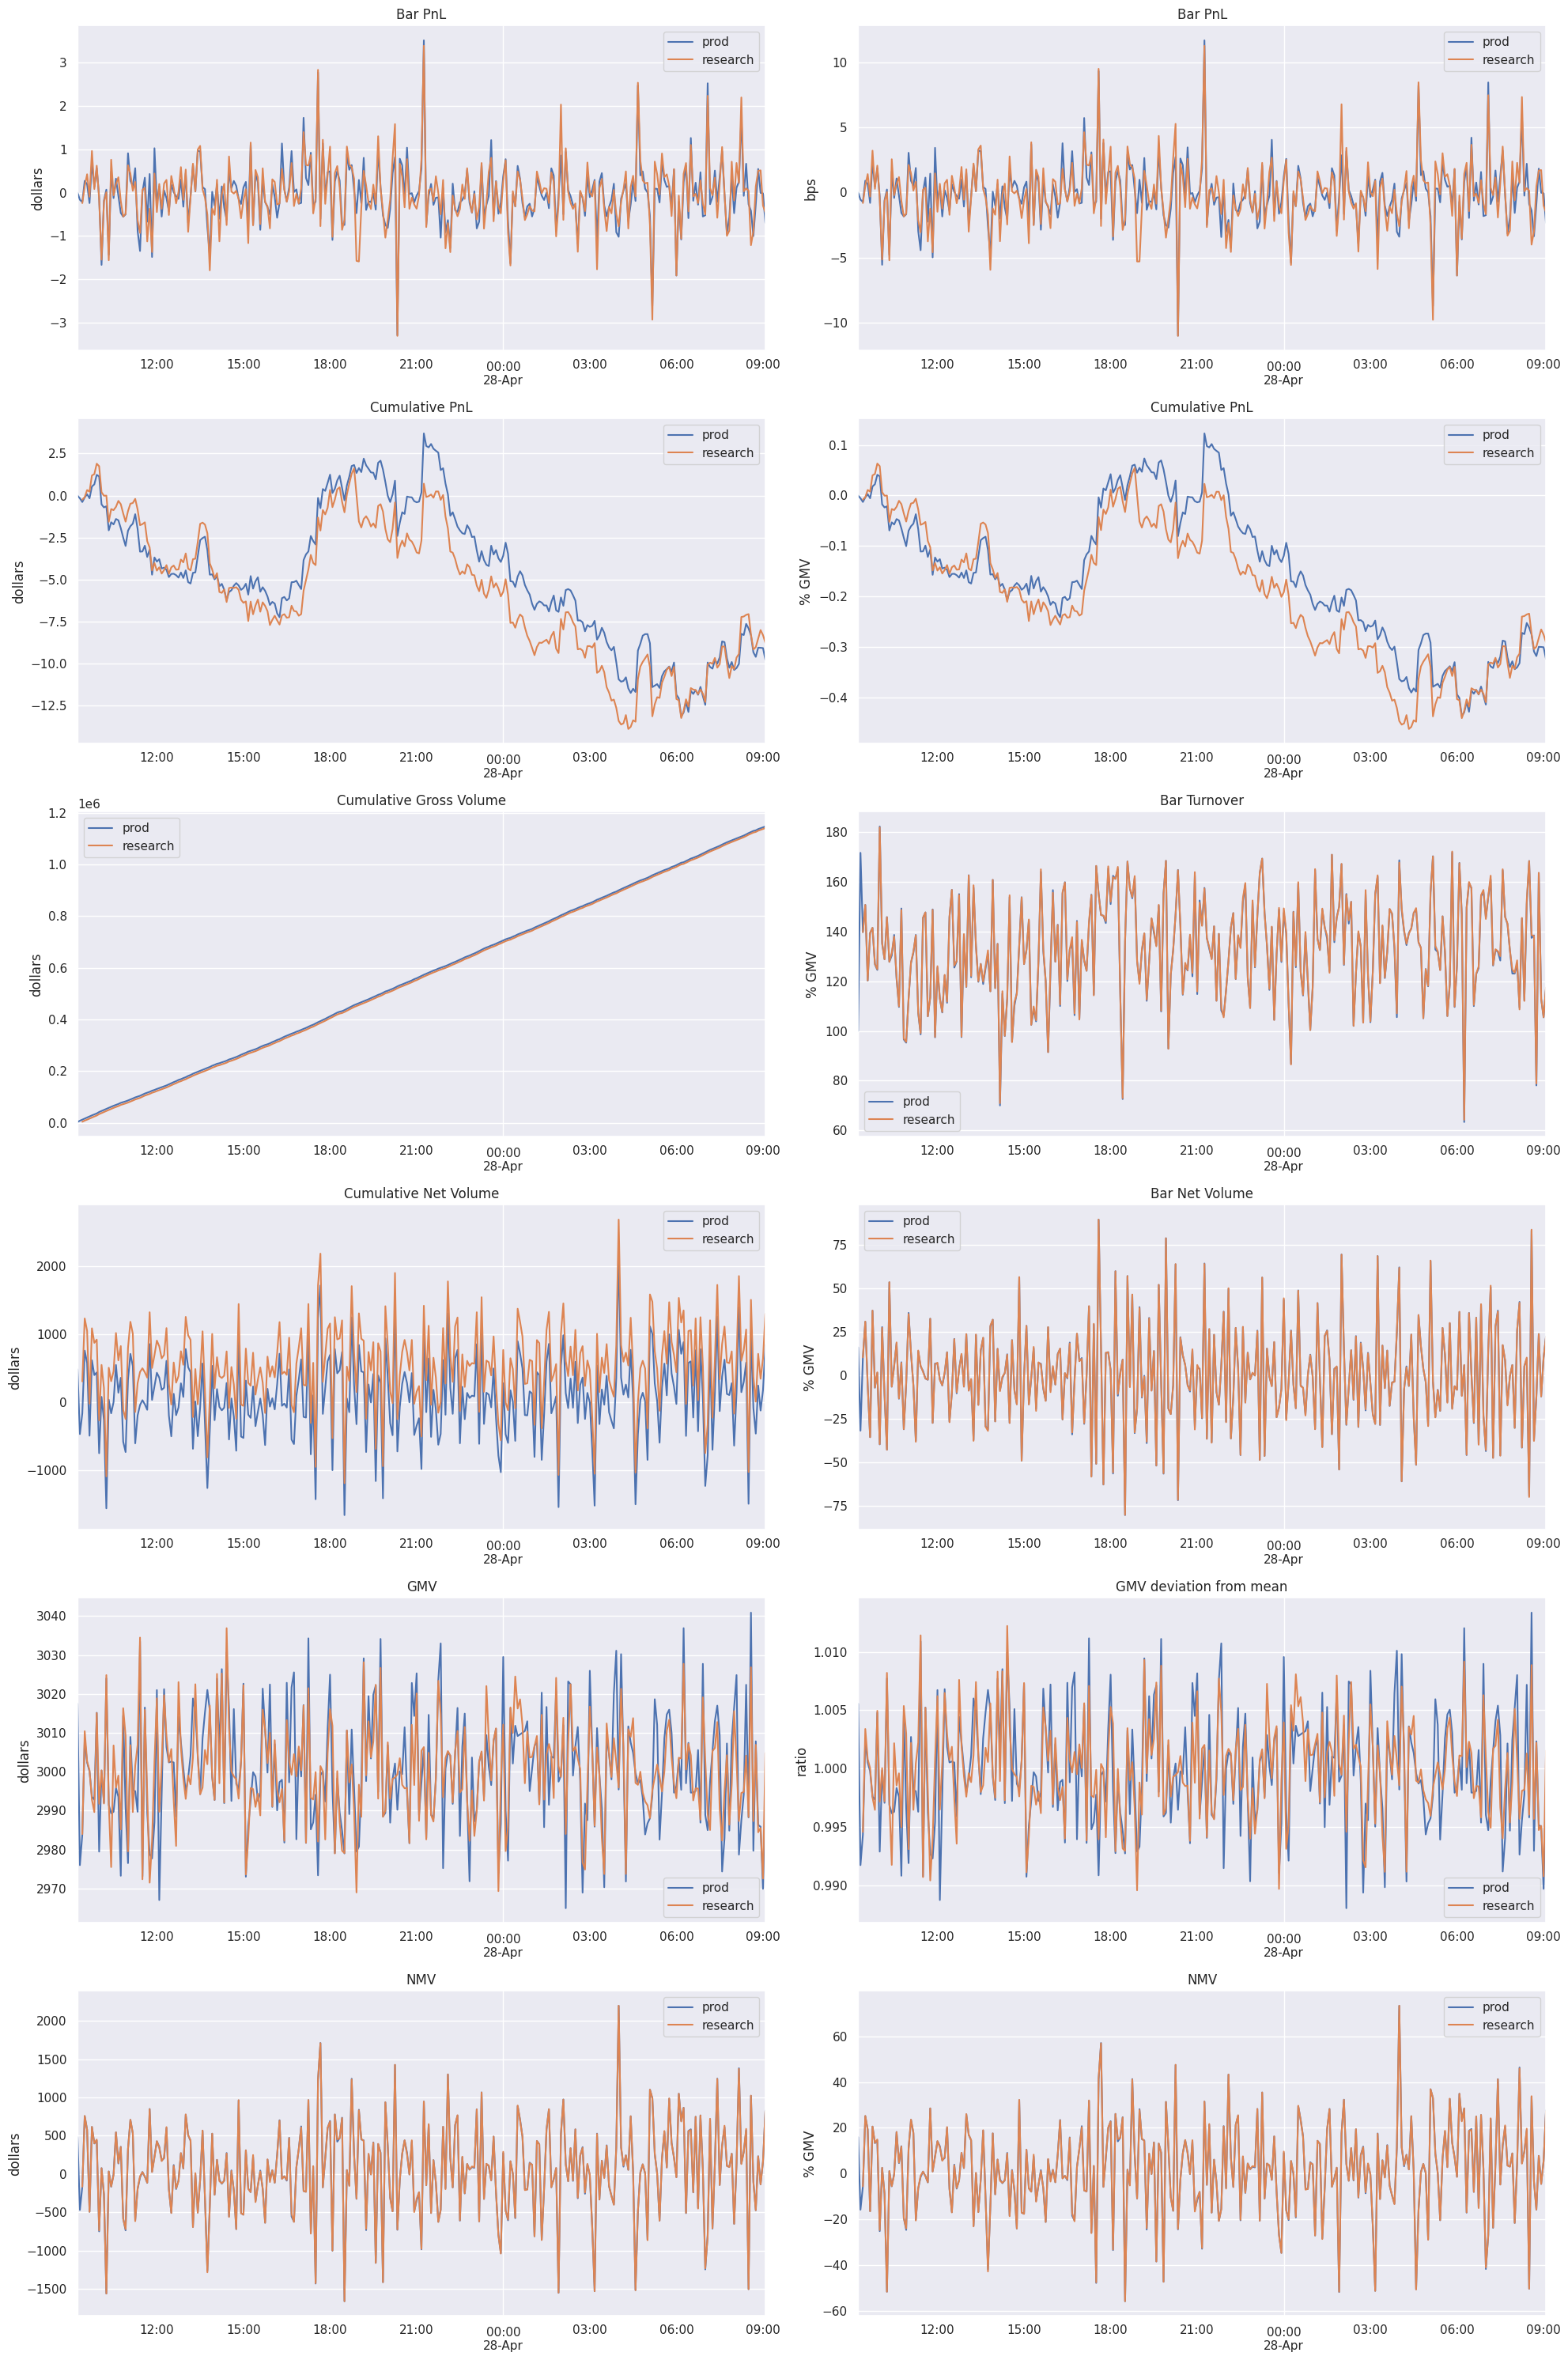

In [21]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [22]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

prod  research
ratios     sharpe_ratio                  -15.73    -13.07
           sharpe_ratio_standard_error    19.19     19.18
           sr.tval                        -0.82     -0.68
           sr.pval                         0.41      0.50
           kratio                        -15.83    -21.10
dollar     gmv_mean                     3000.82   3000.25
           gmv_stdev                      15.02     12.54
           annualized_mean_return      -3582.99  -3211.27
           annualized_volatility         227.85    245.72
           max_drawdown                   16.85     15.79
           pnl_mean                       -0.03     -0.03
           pnl_std                         0.70      0.76
           turnover_mean                3996.42   4002.76
           turnover_stdev                615.80    610.66
           market_bias_mean               61.11     61.97
           market_bias_stdev             592.30    593.03
percentage annualized_mean_return       -119.40   -107.03
           annualized_volatility           7.59      8.19
           max_drawdown                    0.56      0.53
           pnl_mean                       -0.00     -0.00
           pnl_std                         0.02      0.03
           turnover_mean                 133.18    133.41
           turnover_stdev                 20.52     20.35
           market_bias_mean                2.04      2.07
           market_bias_stdev              19.74     19.77

# PnL for investors

In [21]:
# TODO(Grisha): move to a lib.
def adjust_matplotlib_settings() -> None:
    """
    Adjust the Matplotlib settings for readability.
    """
    # Matplotlib setting to make the plots readable in presentations.
    matplotlib.rcParams.update({"font.size": 22})
    #
    BIG_SIZE = 22
    #
    plt.rc("font", size=BIG_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title
    #
    matplotlib.rcParams["figure.dpi"] = 300


# TODO(Grisha): move to a lib.
def plot_cumulative_pnl(
    cumul_pnl: pd.Series,
    plot_title: str,
    *,
    save_to_tmp_file: bool = True,
    copy_to_s3: bool = True,
    s3_dst_file_path: Optional[str] = None,
) -> None:
    """
    Plot cumulative PnL.

    :param cumul_pnl: cumulative PnL
    :param plot_title: title for the plot
    :param save_to_tmp_file: save the plot locally to a tmp file if True,
        proceed otherwise
    :param copy_to_s3: copy to the saved plot to S3 if True, proceed otherwise
    :param s3_dst_file_path: path on S3 to copy the saved plot to, e.g.,
        `s3://.../system_reconciliation/test_image.png`
    """
    adjust_matplotlib_settings()
    # TODO(Grisha): set `target_gmv` properly instead.
    cumul_pnl = cumul_pnl * 1000
    ax = cumul_pnl.plot(title=plot_title)
    # Set the labels formatting, e.g., `1000.0` -> `$1,000`.
    ax.yaxis.set_major_formatter("${x:,.0f}")
    if save_to_tmp_file:
        # Save the plot locally to a tmp file.
        tmp_file_path = "/app/tmp.png"
        _LOG.info("Saving the PnL plot to %s", tmp_file_path)
        plt.savefig(tmp_file_path, bbox_inches="tight")
        if copy_to_s3:
            # Copy a tmp file to S3.
            aws_profile = "ck"
            hs3.copy_file_to_s3(tmp_file_path, s3_dst_file_path, aws_profile)
    # Saving must precede `show()`.
    plt.show()

INFO  Saving the PnL plot to /app/tmp.png
INFO  Copying from /app/tmp.png to s3://cryptokaizen-html/test/cumulative_pnl.last_24hours.png
upload: ../../../tmp.png to s3://cryptokaizen-html/test/cumulative_pnl.last_24hours.png


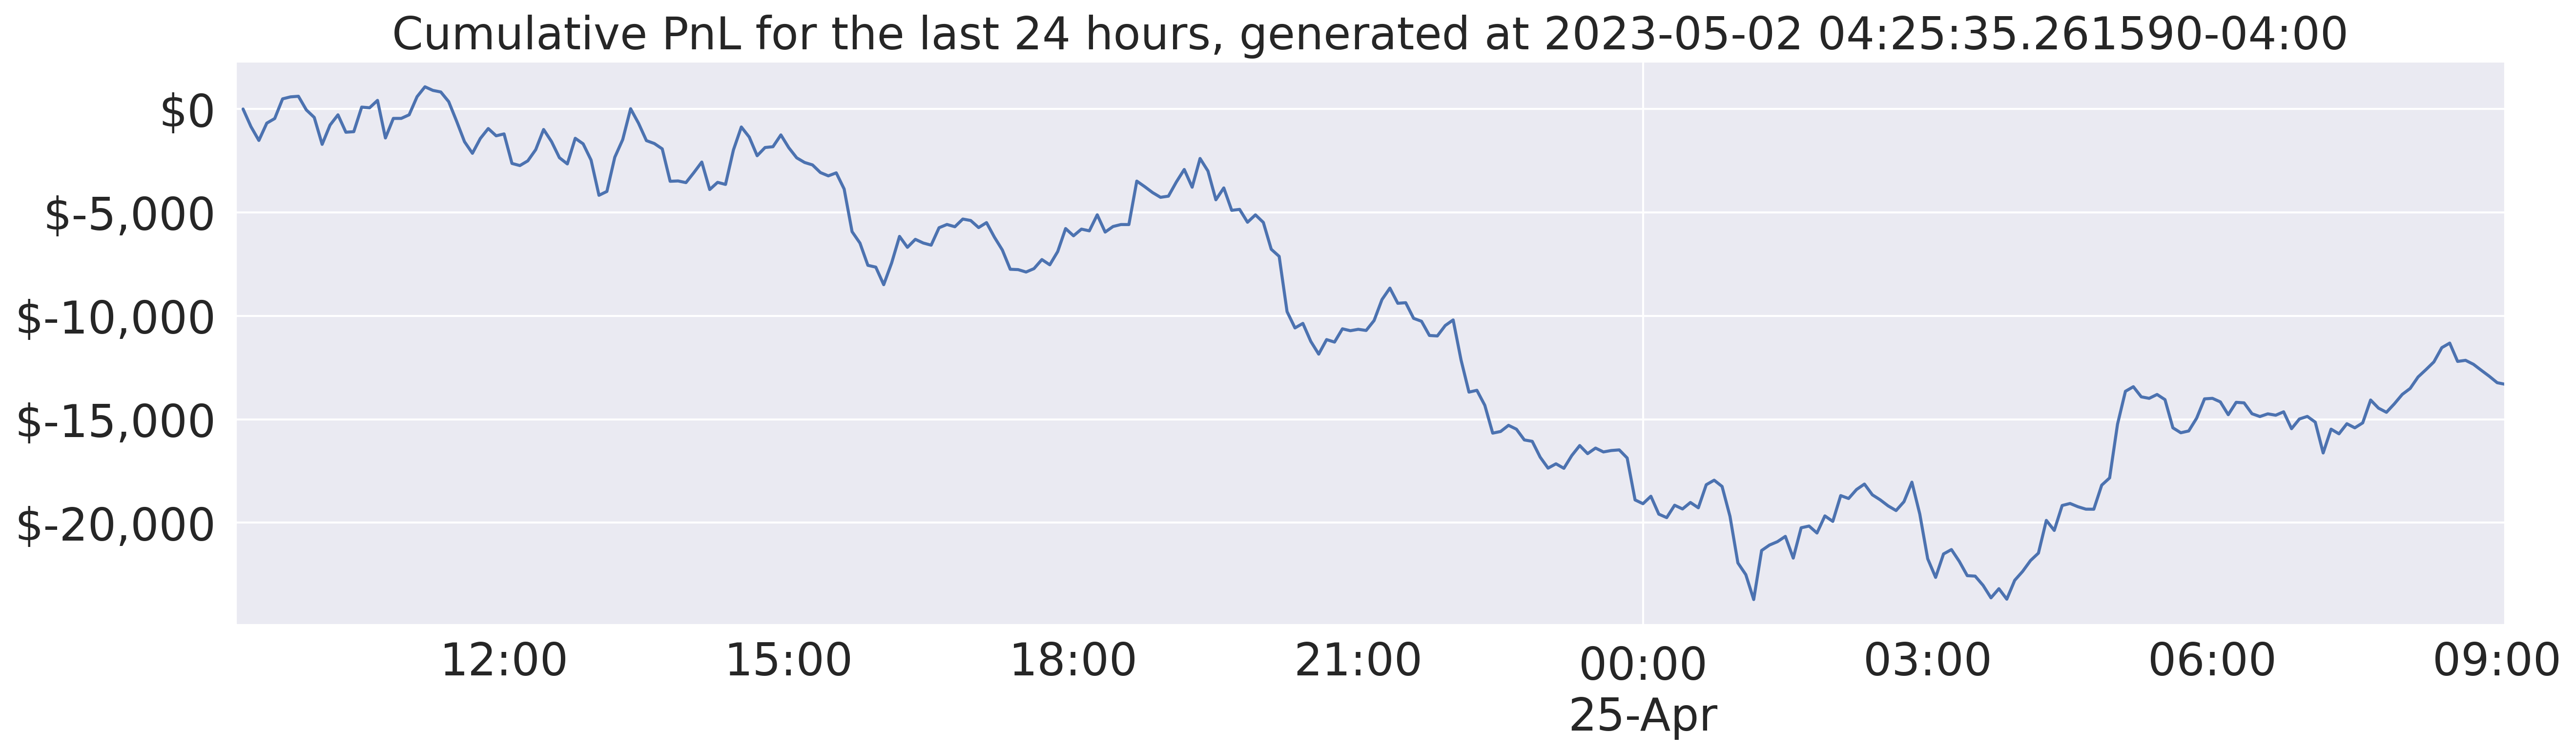

In [24]:
# Save the plots only for C3a.
if (
    config["meta"]["dag_builder_name"] == "C3a"
    and config["meta"]["save_plots_for_investors"]
):
    pnl_df = portfolio_stats_df["prod"]
    # Get the number of hours for which the system is run.
    bar_duration_in_minutes = int(config["meta"]["bar_duration"].rstrip("T"))
    pnl_num_hours = pnl_df.shape[0] * bar_duration_in_minutes / 60
    # Verify that the number of hours is in [0,24] range.
    hdbg.dassert_lgt(
        0,
        pnl_num_hours,
        24,
        lower_bound_closed=False,
        upper_bound_closed=True,
    )
    # TODO(Grisha): this is a hack. Ideally we should schedule a DAG
    # after the prod run is finished to get a plot for 24 hours.
    current_et_time = hdateti.get_current_time("ET")
    if round(pnl_num_hours) == 24:
        # A 24 hours run is a complete run so save as the last 24 hours results.
        file_name = "cumulative_pnl.last_24hours.png"
        plot_title = f"Cumulative PnL for the last 24 hours, generated at {current_et_time}"
    else:
        # If a run is not complete save as last 5 minutes results.
        file_name = "cumulative_pnl.last_5minutes.png"
        plot_title = f"Cumulative PnL for the last 5 minutes, generated at {current_et_time}"
    cumul_pnl = pnl_df["pnl"].cumsum()
    s3_dst_path = os.path.join(config["s3_dst_dir"], file_name)
    save_to_tmp_file = True
    copy_to_s3 = True
    plot_cumulative_pnl(
        cumul_pnl,
        plot_title,
        save_to_tmp_file=save_to_tmp_file,
        copy_to_s3=copy_to_s3,
        s3_dst_file_path=s3_dst_path,
    )